In [1]:
!pip install google-api-python-client nltk textblob wordcloud isodate langdetect seaborn statsmodels scikit-learn

In [2]:
# Core
import pandas as pd
import numpy as np
import re

# YouTube API
from googleapiclient.discovery import build

# NLP & Sentiment
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
from langdetect import detect
import isodate

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, accuracy_score, classification_report
)

# Optional (multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


In [3]:
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [32]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [4]:
API_KEY = "My key"
CHANNEL_ID = "UCsT0YIqwnpJCM-mx7-gSA4Q"

youtube = build(
    "youtube",
    "v3",
    developerKey=API_KEY
)

In [5]:
response = youtube.channels().list(
    part="snippet",
    id=CHANNEL_ID
).execute()

print(response)

{'kind': 'youtube#channelListResponse', 'etag': 'F2e4HFm_DwdHTCz8ai6lUyvOECw', 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5}, 'items': [{'kind': 'youtube#channel', 'etag': '1SVK5dR6GHBCCapxg44K5kM1A8M', 'id': 'UCsT0YIqwnpJCM-mx7-gSA4Q', 'snippet': {'title': 'TEDx Talks', 'description': "TEDx is an international community that organizes TED-style events anywhere and everywhere -- celebrating locally-driven ideas and elevating them to a global stage. TEDx events are produced independently of TED conferences, each event curates speakers on their own, but based on TED's format and rules.\n\nFor more information on using TED for commercial purposes (e.g. employee learning, in a film or online course), please submit a Media Request here: https://media-requests.ted.com.", 'customUrl': '@tedx', 'publishedAt': '2009-06-23T16:00:48Z', 'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/1gDPO-4YPWFErfn3yQBnv0yxpkmiud1m5CrorApkOqUYdNd9FrZQ9xB9C9VmDt4EsgArnlwqAQc=s88-c-k-c0x00ffffff-no-

In [6]:
channel_response = youtube.channels().list(
    part="contentDetails",
    id=CHANNEL_ID
).execute()

uploads_playlist_id = channel_response["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
print("Uploads playlist ID:", uploads_playlist_id)

Uploads playlist ID: UUsT0YIqwnpJCM-mx7-gSA4Q


In [7]:
all_video_ids = []
next_page_token = None

while True:
    pl_request = youtube.playlistItems().list(
        part="snippet",
        playlistId="UUsT0YIqwnpJCM-mx7-gSA4Q",
        maxResults=50,
        pageToken=next_page_token
    )
    pl_response = pl_request.execute()
    
    for item in pl_response['items']:
        all_video_ids.append(item['snippet']['resourceId']['videoId'])
    
    next_page_token = pl_response.get('nextPageToken')
    if not next_page_token:
        break

print(f"Total videos found: {len(all_video_ids)}")
print(all_video_ids[:10])

Total videos found: 20000
['IM0e621hDL4', 'xJ4Y0J4O3lQ', 'yFfgV_7EKfE', 'VcehrgZtGSY', 'X9p2BxSMfBc', '7tX5Wc9ti_M', 'jFs5cnhRUwg', 'HsUqaq6K5Eg', 'XZQMVYSD9EM', 'ZD9tYfZa8TU']


In [10]:
all_videos = []
for i in range(0, len(all_video_ids), 50):
    video_ids_chunk = all_video_ids[i:i+50]
    
    vid_request = youtube.videos().list(
        part="snippet,statistics,contentDetails",
        id=",".join(video_ids_chunk)
    )
    vid_response = vid_request.execute()
    
    for item in vid_response['items']:
        snippet = item['snippet']
        stats = item.get('statistics', {})
        content_details = item.get('contentDetails', {})
        
        # Duration conversion
        duration_iso = content_details.get('duration', 'PT0S')
        duration_sec = int(isodate.parse_duration(duration_iso).total_seconds())
        
        all_videos.append({
            'video_id': item['id'],
            'title': snippet.get('title', ''),
            'description': snippet.get('description', ''),
            'published_at': snippet.get('publishedAt', ''),
            'view_count': int(stats.get('viewCount', 0)),
            'like_count': int(stats.get('likeCount', 0)),
            'comment_count': int(stats.get('commentCount', 0)),
            'favorite_count': int(stats.get('favoriteCount', 0)),
            'duration': duration_sec,
            'tags_count': len(snippet.get('tags', [])),
            'title_length': len(snippet.get('title', '')),
            'description_length': len(snippet.get('description', '')),
            'published_year': pd.to_datetime(snippet.get('publishedAt')).year if snippet.get('publishedAt') else None,
            'published_month': pd.to_datetime(snippet.get('publishedAt')).month if snippet.get('publishedAt') else None
        })

In [11]:
df = pd.DataFrame(all_videos)
print(df.head())
print(df.shape)

      video_id                                              title  \
0  IM0e621hDL4  Can we end fear-driven healthcare? | Mel Thack...   
1  xJ4Y0J4O3lQ  Should Tech Bros Be Working with Tech Mums? | ...   
2  yFfgV_7EKfE  How the universe began—and how it is likely to...   
3  VcehrgZtGSY  Why sharks and rays keep our oceans alive | Lo...   
4  X9p2BxSMfBc  Navigating Human Creativity in the Age of AI |...   

                                         description          published_at  \
0  Humans tend to rely on white swans—the known k...  2025-12-22T18:00:32Z   
1  Professor Sue Black uses her own life story to...  2025-12-22T17:18:26Z   
2  Prof Carlos Frenk presents in his home city to...  2025-12-22T17:18:12Z   
3  Imagine an ocean without sharks and rays: murk...  2025-12-22T17:17:44Z   
4  In an age shaped by artificial intelligence, w...  2025-12-22T17:16:47Z   

   view_count  like_count  comment_count  favorite_count  duration  \
0        1588         104             14      

In [12]:
#  Ստեղծում ենք 'text' սյուն՝ title + description
df['description'] = df['description'].fillna('')  # եթե կա missing
df['text'] = df['title'] + ' ' + df['description']

#  Sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

#  Sentiment classification (positive / negative / neutral)
def sentiment_class(polarity):
    if polarity > 0:
        return 1
    elif polarity < 0:
        return -1
    else:
        return 0

df['sentiment_class'] = df['sentiment'].apply(sentiment_class)

# Text length features
df['title_length'] = df['title'].apply(len)
df['description_length'] = df['description'].apply(len)
df['text_length'] = df['text'].apply(len)

#  Word count features
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))
df['description_word_count'] = df['description'].apply(lambda x: len(x.split()))
df['text_word_count'] = df['text'].apply(lambda x: len(x.split()))

#  Published date features
df['published_at'] = pd.to_datetime(df['published_at'])
df['day'] = df['published_at'].dt.day
df['weekday'] = df['published_at'].dt.weekday  # 0=Monday


In [13]:
print(df.columns)

Index(['video_id', 'title', 'description', 'published_at', 'view_count',
       'like_count', 'comment_count', 'favorite_count', 'duration',
       'tags_count', 'title_length', 'description_length', 'published_year',
       'published_month', 'text', 'sentiment', 'sentiment_class',
       'text_length', 'title_word_count', 'description_word_count',
       'text_word_count', 'day', 'weekday'],
      dtype='object')


In [14]:
df.isnull().sum()


video_id                  0
title                     0
description               0
published_at              0
view_count                0
like_count                0
comment_count             0
favorite_count            0
duration                  0
tags_count                0
title_length              0
description_length        0
published_year            0
published_month           0
text                      0
sentiment                 0
sentiment_class           0
text_length               0
title_word_count          0
description_word_count    0
text_word_count           0
day                       0
weekday                   0
dtype: int64

In [15]:
print(df.dtypes)

video_id                               object
title                                  object
description                            object
published_at              datetime64[ns, UTC]
view_count                              int64
like_count                              int64
comment_count                           int64
favorite_count                          int64
duration                                int64
tags_count                              int64
title_length                            int64
description_length                      int64
published_year                          int64
published_month                         int64
text                                   object
sentiment                             float64
sentiment_class                         int64
text_length                             int64
title_word_count                        int64
description_word_count                  int64
text_word_count                         int64
day                               

In [16]:
df['published_at'] = pd.to_datetime(df['published_at'])

In [18]:
df.head(5)

,video_id,title,description,published_at,view_count,like_count,comment_count,favorite_count,duration,tags_count,...,published_month,text,sentiment,sentiment_class,text_length,title_word_count,description_word_count,text_word_count,day,weekday
0,IM0e621hDL4,Can we end fear-driven healthcare? | Mel Thack...,Humans tend to rely on white swans—the known k...,2025-12-22 18:00:32+00:00,1588,104,14,0,800,6,...,12,Can we end fear-driven healthcare? | Mel Thack...,0.006667,1,872,10,127,137,22,0
1,xJ4Y0J4O3lQ,Should Tech Bros Be Working with Tech Mums? | ...,Professor Sue Black uses her own life story to...,2025-12-22 17:18:26+00:00,42,0,0,0,1128,7,...,12,Should Tech Bros Be Working with Tech Mums? | ...,0.196329,1,1191,14,182,196,22,0
2,yFfgV_7EKfE,How the universe began—and how it is likely to...,Prof Carlos Frenk presents in his home city to...,2025-12-22 17:18:12+00:00,219,12,4,0,948,9,...,12,How the universe began—and how it is likely to...,-0.033333,-1,1008,16,150,166,22,0
3,VcehrgZtGSY,Why sharks and rays keep our oceans alive | Lo...,Imagine an ocean without sharks and rays: murk...,2025-12-22 17:17:44+00:00,40,1,0,0,535,10,...,12,Why sharks and rays keep our oceans alive | Lo...,0.139048,1,1510,15,219,234,22,0
4,X9p2BxSMfBc,Navigating Human Creativity in the Age of AI |...,"In an age shaped by artificial intelligence, w...",2025-12-22 17:16:47+00:00,28,0,0,0,331,10,...,12,Navigating Human Creativity in the Age of AI |...,0.158333,1,1541,13,217,230,22,0


In [19]:
print(f"Կրկնվող տողերի քանակը: {df.duplicated(subset=['video_id']).sum()}")

Կրկնվող տողերի քանակը: 0


In [20]:
# Ստուգել առաջին 10 արժեքները
print(df[['video_id', 'sentiment', 'sentiment_class']].head(10))

      video_id  sentiment  sentiment_class
0  IM0e621hDL4   0.006667                1
1  xJ4Y0J4O3lQ   0.196329                1
2  yFfgV_7EKfE  -0.033333               -1
3  VcehrgZtGSY   0.139048                1
4  X9p2BxSMfBc   0.158333                1
5  7tX5Wc9ti_M   0.271818                1
6  jFs5cnhRUwg   0.150000                1
7  HsUqaq6K5Eg   0.101923                1
8  XZQMVYSD9EM   0.108065                1
9  ZD9tYfZa8TU   0.145455                1


Sentiment սյունը ցույց է տալիս polarity (միջակայք՝ -1 → 1):

Sentiment_class սյունը ցույց է տալիս դասակարգումը (-1՝ բացասական, 0՝ չեզոք, 1՝ դրական):

In [62]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def is_english(text):
    try:
        return detect(str(text)) == 'en'
    except LangDetectException:
        return False
# 1. Ֆիլտրում ենք անգլերեն վիդեոները և մաքրում ինդեքսները
df['is_english'] = df['title'].apply(is_english)
df_en = df[df['is_english']].copy().reset_index(drop=True)

# 2. Լավարկված text cleaning ֆունկցիա
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URL-եր
    text = re.sub(r'\d+', ' ', text)                   # թվերի հեռացում
    text = re.sub(r'[^a-z\s]', ' ', text)              # նշանների հեռացում
    text = re.sub(r'\b[a-z]\b', ' ', text)             # մեկ տառանոց բառեր
    text = re.sub(r'\s+', ' ', text).strip()           # ավելորդ բացատներ
    return text
from nltk import pos_tag
from nltk.tokenize import word_tokenize

ALLOWED_POS = {
    'NN', 'NNS', 'NNP', 'NNPS'  # nouns
    
}

def pos_filter(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    return ' '.join(
        word for word, tag in tagged if tag in ALLOWED_POS
    )
df_en['text'] = (
    df_en['title'] + " " + df_en['description']
).apply(clean_text).apply(pos_filter)

# 3. Stop Words 
extra_stop_words = {
    'talk', 'talks', 'ted', 'tedx', 'event', 'events', 'organized',
    'independently', 'using', 'local', 'community', 'conference',
    'format', 'ideas', 'speaker', 'speakers', 'stage', 'audience',
    'university', 'presented', 'world', 'years', 'just', 'really',
    'experience', 'work', 'one', 'two', 'also', 'well', 'much', 'many',
    'dr', 'mr', 'mrs', 'ms', 'msc', 'phd', 'bsc', 'ba', 'ma',
    'di', 'il', 'la', 'le', 'un', 'del', 'que','md', 'unknown', 'uncover','che','husband', 'wife', 'board', 'forward','shares','change','lives','introduction','john','joe'
}

final_stop_words = list(ENGLISH_STOP_WORDS.union(extra_stop_words))


In [63]:
# 4. TF-IDF վեկտորիզացիա 
tfidf = TfidfVectorizer(
    max_features=3000, 
    stop_words=final_stop_words, 
    min_df=2, 
    ngram_range=(1, 2),
    token_pattern=r'(?u)\b[a-z]{2,}\b'
)
tfidf_matrix = tfidf.fit_transform(df_en['text'])

# 5. DataFrame-ի ստեղծում
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=df_en.index
)

df_final = pd.concat([
    df_en[['video_id', 'title', 'view_count', 'published_at', 'published_year', 'sentiment', 'sentiment_class']], 
    tfidf_df
], axis=1)

# Սահմանում ենք df_master
df_master = df_final

print("df_master")
print(df_master[['published_year', 'sentiment']].head())

df_master
   published_year  sentiment
0            2025   0.006667
1            2025   0.196329
2            2025  -0.033333
3            2025   0.139048
4            2025   0.158333


In [64]:
first_video_keywords = tfidf_df.iloc[0]
print(first_video_keywords[first_video_keywords > 0].sort_values(ascending=False).head(10))

surgeon          0.563875
marathons        0.317373
podcaster        0.304029
massachusetts    0.301787
phenomenon       0.284804
specialist       0.229536
humans           0.219162
medicine         0.191158
fear             0.185694
language         0.178892
Name: 0, dtype: float64


Կիրառել եմ լեզվի ֆիլտրում, տեքստի նորմալացում, բառատեսակների (POS) վրա հիմնված գոյականների առանձնացում և TF-IDF վեկտորիզացիա՝ իմաստային առումով նշանակալի բանալի բառեր ստանալու համար»։

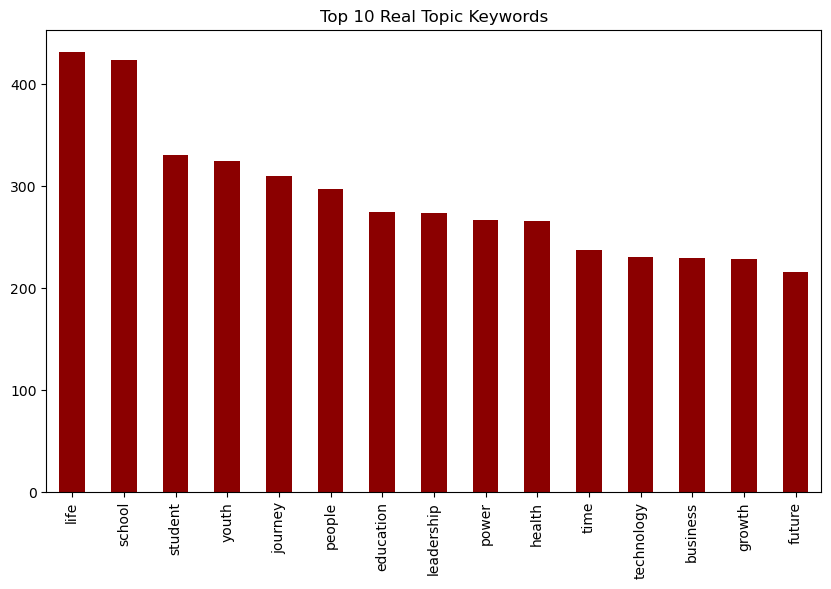

In [65]:
# Հաշվում ենք յուրաքանչյուր բառի ընդհանուր կարևորությունը
top_content_words = tfidf_df.sum().sort_values(ascending=False).head(15)
top_content_words.plot(kind='bar', color='darkred', figsize=(10,6))
plt.title('Top 10 Real Topic Keywords')
plt.show()

Կրթություն և Սերունդներ: school, youth, student բառերը թոփ հնգյակում են։ Սա նշանակում է, որ TEDx-ը հիմնականում կրթական և երիտասարդությանն ուղղված հարթակ է։

Անհատական աճ: life, journey, personal, leadership, growth բառերը փաստում են, որ մարդկային պատմությունները և փոփոխությունները կենտրոնական թեմաներ են։

Տեխնոլոգիա, business արդեն հասցրել է բարձրանալ թոփ 10-ի մեջ, ինչը շատ արդիական է։

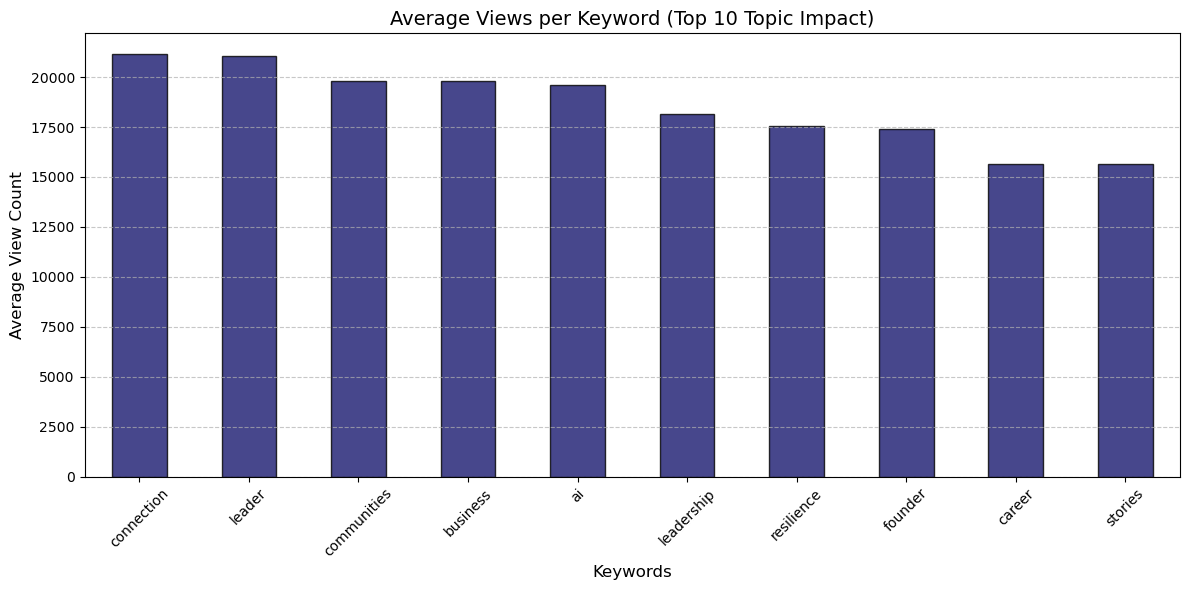

In [66]:
# 1. Հաշվում ենք յուրաքանչյուր բառի միջին դիտումները
top_50_words = tfidf_df.sum().sort_values(ascending=False).head(50).index
word_impact = {}

for word in top_50_words:
    # Վերցնում ենք միջին դիտումները միայն այն վիդեոների համար, որտեղ տվյալ բառի կշիռը 0-ից մեծ է
    avg_views = df_final[df_final[word] > 0]['view_count'].mean()
    word_impact[word] = avg_views

# 2. Սարքում ենք գրաֆիկ (վերցնում ենք թոփ 20-ը ըստ դիտումների)
impact_series = pd.Series(word_impact).sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
# Գույնը փոխված է 'midnightblue' (մուգ կապույտ)
impact_series.plot(kind='bar', color='midnightblue', edgecolor='black', alpha=0.8)

plt.title('Average Views per Keyword (Top 10 Topic Impact)', fontsize=14)
plt.ylabel('Average View Count', fontsize=12)
plt.xlabel('Keywords', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Ավելացրեցի ցանց՝ ավելի հեշտ կարդալու համար

plt.tight_layout()
plt.show()

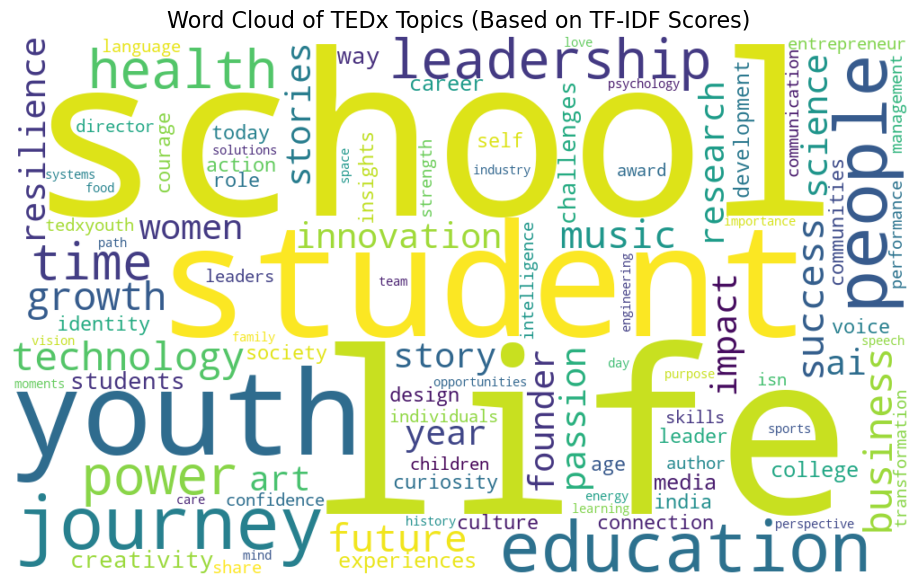

In [67]:
weights = tfidf_df.mean().to_dict()

# Ստեղծում ենք Word Cloud օբյեկտը
# Հեռացնում ենք քո նշած բառերը հենց բառարանից նախքան գեներացնելը
exclude_words = ['years', 'just', 'dr', 'experience', 'work', 'university']
filtered_weights = {k: v for k, v in weights.items() if k not in exclude_words}

wordcloud = WordCloud(
    width=1000, 
    height=600, 
    background_color='white', 
    colormap='viridis',  # Գեղեցիկ գունային գամմա
    max_words=100        # Ցույց տալ թոփ 100 կարևոր բառերը
).generate_from_frequencies(filtered_weights)

# Ցուցադրում
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Առանց առանցքների
plt.title('Word Cloud of TEDx Topics (Based on TF-IDF Scores)', fontsize=16)
plt.show()

In [68]:
main_topic_series = tfidf_df.idxmax(axis=1)

# Ավելացնում ենք df_master-ի մեջ
df_master.loc[:, 'main_topic'] = main_topic_series.values

# Duplicate column cleanup
df_master = df_master.loc[:, ~df_master.columns.duplicated()]

# 1) sentiment_class → label
sentiment_map = {1: "Positive", 0: "Neutral", -1: "Negative"}
df_master['sentiment_label'] = df_master['sentiment_class'].map(sentiment_map)

# 2) Մաքուր աղյուսակ
final_cols = [
    'video_id', 'title', 'main_topic',
    'sentiment', 'sentiment_class', 'sentiment_label',
    'view_count'
]
df_master_clean = df_master[final_cols].copy()

print("Աղյուսակը մաքրված է:")
print(df_master_clean.tail(4))



Աղյուսակը մաքրված է:
          video_id                                              title  \
14689  XiUXb9crMNw  Adherence to Nepal’s Tax Regulations | CA. Pra...   
14690  h2cY9Sz7ox4  Nepal’s Path Toward a Sustainable and Broad-Ba...   
14691  diYEjLLFGuk  Lettering Artist, Graphic Designer & Educator ...   
14692  5p5FqCXuI5o  The important of critical thinking  | Syarifah...   

      main_topic  sentiment  sentiment_class sentiment_label  view_count  
14689        tax   0.153175                1        Positive         638  
14690   minister   0.150595                1        Positive         478  
14691     design   0.133333                1        Positive         267  
14692   thinking   0.108333                1        Positive         414  


In [69]:
# 3) Aggregation: միջին դիտումներ ըստ main_topic
topic_avg_views = (
    df_master_clean.groupby('main_topic', as_index=False)['view_count']
    .mean()
    .sort_values('view_count', ascending=False)
)

print("\nՄիջին դիտումներ ըստ թեմայի (Top 10):")
print(topic_avg_views.head(10))


Միջին դիտումներ ըստ թեմայի (Top 10):
            main_topic    view_count
1271           lawyers  1.449756e+06
1854      relationship  1.423975e+06
2178            supply  8.296890e+05
997   harvard business  7.473310e+05
2295             trade  6.911064e+05
1762         processes  5.036025e+05
643     discrimination  4.081312e+05
543              cyber  3.927627e+05
2046              skin  3.687409e+05
1819              rank  3.037560e+05


In [71]:
# Median դիտումներ ըստ main_topic (outlier-ներից պաշտպանված)
topic_median_views = (
    df_master_clean.groupby('main_topic', as_index=False)['view_count']
    .median()
    .sort_values('view_count', ascending=False)
)

print("\nՄեդիան դիտումներ ըստ թեմայի (Top 5):")
print(topic_median_views.head(5))


Մեդիան դիտումներ ըստ թեմայի (Top 5):
            main_topic  view_count
2178            supply    829689.0
997   harvard business    747331.0
1762         processes    503602.5
1819              rank    303756.0
1277  leadership coach    242232.0


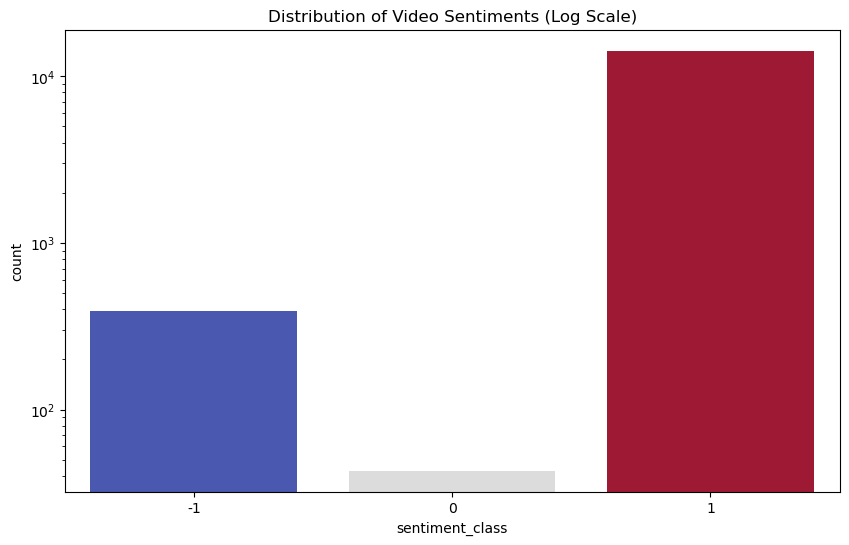

In [73]:
# 1. Distribution of Sentiment Classes
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_class', data=df_master_clean, palette='coolwarm', hue='sentiment_class', legend=False)
plt.yscale('log') # Ավելացրու սա՝ փոքր քանակները տեսնելու համար
plt.title('Distribution of Video Sentiments (Log Scale)')
plt.show()

Բացարձակ փոզիտիվ: Գրեթե բոլոր վիդեոները (ավելի քան 14,000-ը) ունեն դրական տոնայնություն։

Քիչ բացասականություն: Բացասական կամ քննադատական տոնայնությամբ վիդեոները քիչ են։ Սա ապացուցում է TED-ի առաքելությունը՝ տարածել հույս և լուծումներ ներշնչող գաղափարներ։

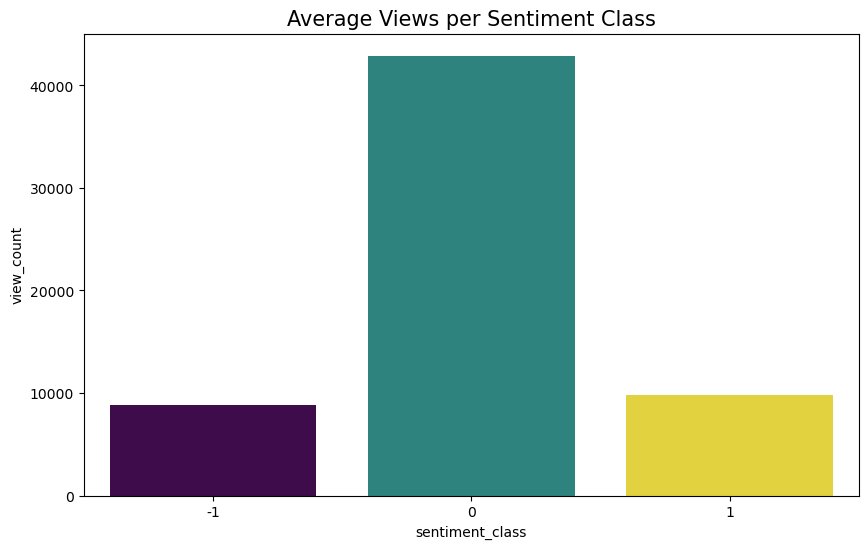

In [74]:
# 2. Average Views by Sentiment Class
plt.figure(figsize=(10, 6))
avg_views = df_master_clean.groupby('sentiment_class')['view_count'].mean().reset_index()
# Ավելացրել ենք hue='sentiment_class'
sns.barplot(x='sentiment_class', y='view_count', data=avg_views, palette='viridis', hue='sentiment_class', legend=False)
plt.title('Average Views per Sentiment Class', fontsize=15)
plt.show()

Չեզոք վիդեոները «հիթեր» են. Թեև չեզոք վիդեոները քիչ են (ընդամենը 44 հատ), դրանք միջինում ունեն շատ բարձր դիտումներ (մոտ 42,000 դիտում)։ Սա կարող է նշանակել, որ գիտական կամ փաստագրական վիդեոները, որոնք զերծ են էմոցիաներից (չեզոք են), մեծ հետաքրքրություն են առաջացնում։

Սանդղակի տարբերություն. Առաջին գրաֆիկը ցույց է տալիս քանակը (Count), իսկ երկրորդը՝ միջին արժեքը (Mean)։ Փոքր քանակով խումբը կարող է ունենալ շատ բարձր միջին արժեք, եթե այդ 44 վիդեոների մեջ կան մի քանի «վիրուսային» դիտվողներ։

In [75]:
print(df_master_clean['sentiment_class'].value_counts())

sentiment_class
 1    14259
-1      391
 0       43
Name: count, dtype: int64


«Թեև TEDx վիդեոների ճնշող մեծամասնությունը (97%) դրական է, ամենաբարձր միջին դիտումները ստացել են չեզոք տոնայնություն ունեցող տեսանյութերը։ Սա հուշում է, որ լսարանը բարձր է գնահատում օբյեկտիվ և տեղեկատվական բովանդակությունը»։

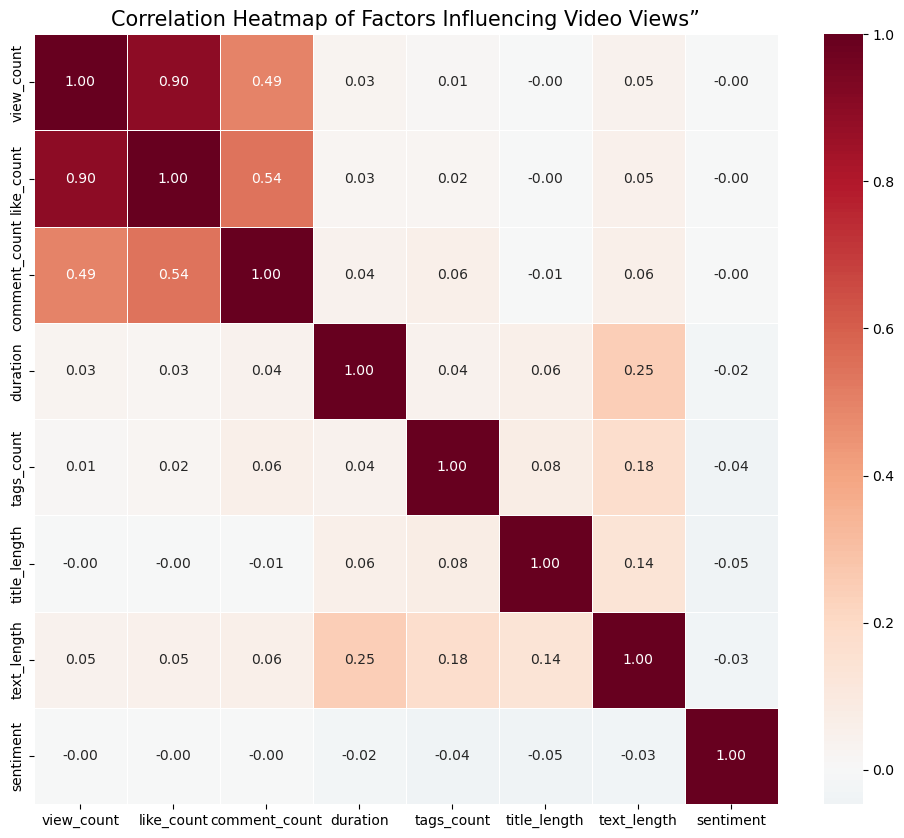

In [85]:
available_numeric = [
    'view_count', 'like_count', 'comment_count', 'duration', 
    'tags_count', 'title_length', 'text_length', 'sentiment'
]

cols_to_use = [c for c in available_numeric if c in df_en.columns]

plt.figure(figsize=(12, 10))

# 3. Հաշվում ենք կորելացիան df_en-ի վրա
correlation_matrix = df_en[cols_to_use].corr()

# 4. Գծում ենք heatmap-ը
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap of Factors Influencing Video Views”', fontsize=15)
plt.show()

Կորելացիոն քարտեզը ցույց է տալիս, որ դիտումների քանակը ուժեղ կապ ունի like-երի և comment-ների հետ, մինչդեռ տեքստային հատկանիշները (վերնագրի/տեքստի երկարություն, sentiment) ունեն շատ թույլ կամ գրեթե զրոյական ազդեցություն դիտումների վրա։ Սա վկայում է, որ օգտատերերի ներգրավվածությունը ավելի կարևոր գործոն է, քան լեզվական կամ էմոցիոնալ հատկանիշները։

In [77]:
df_master['published_at'].dt.year.value_counts()

published_at
2025    14693
Name: count, dtype: int64

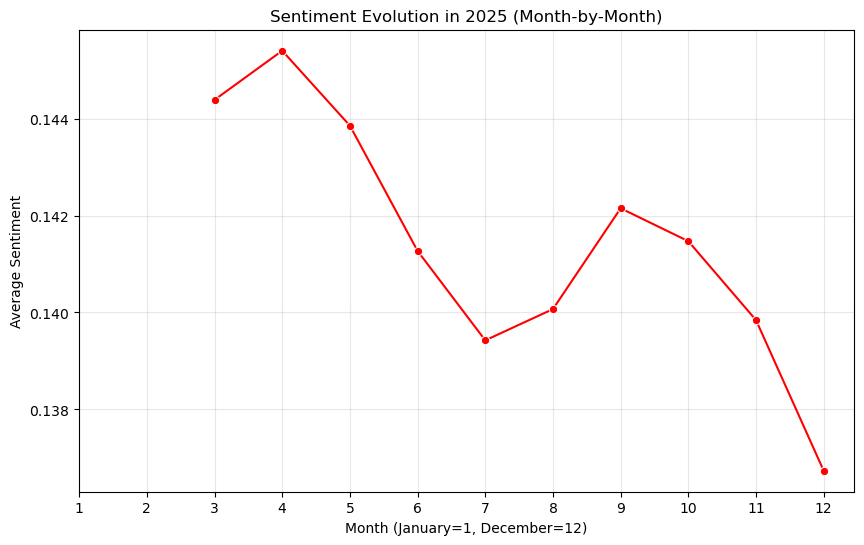

In [78]:
# 1. 
df_master = df_master.drop_duplicates(subset=['video_id'])

# 2. Ստեղծում ենք 'month' սյունակը
df_master['month'] = df_master['published_at'].dt.month

# 3. Հաշվում ենք ամսական միջին սենտիմենտը
monthly_trend = df_master.groupby('month')['sentiment'].mean().reset_index()

# 4. գրաֆիկը
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_trend, x='month', y='sentiment', marker='o', color='red')

plt.title('Sentiment Evolution in 2025 (Month-by-Month)')
plt.xlabel('Month (January=1, December=12)')
plt.ylabel('Average Sentiment')
plt.xticks(range(1, 13)) # Ցույց տալ բոլոր 12 ամիսները
plt.grid(True, alpha=0.3)
plt.show()

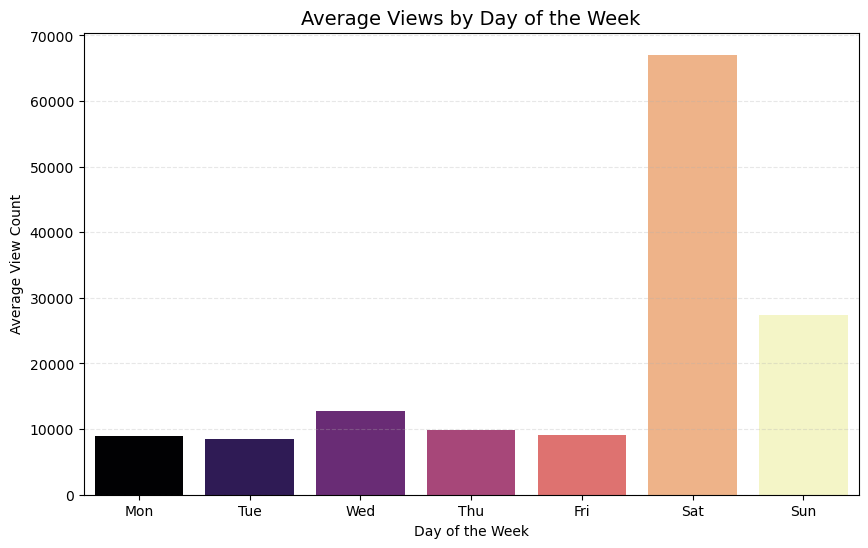

In [79]:
plt.figure(figsize=(10, 6))

# Հաշվում ենք միջին դիտումները ըստ շաբաթվա օրերի
weekday_avg = df_en.groupby('weekday')['view_count'].mean().reset_index()

sns.barplot(
    data=weekday_avg, 
    x='weekday', 
    y='view_count', 
    hue='weekday', 
    palette='magma', 
    legend=False
)

plt.title('Average Views by Day of the Week', fontsize=14)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Average View Count')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

Հանգստյան օրերի գերիշխանություն. Գրաֆիկը հստակ ցույց է տալիս, որ Շաբաթ (Sat) օրը հրապարակված տեսանյութերը ստանում են ամենաբարձր միջին դիտումները՝ անցնելով 60,000-ի սահմանը:

Timing-ի գործոնը. Երկրորդ ամենահաջողակ օրը Կիրակին (Sun) է: Սա փաստում է, որ լսարանը TEDx-ի նման կրթական բովանդակությունը նախընտրում է դիտել հանգստյան օրերին, երբ ունի ավելի շատ ազատ ժամանակ:

Աշխատանքային օրերի պասիվություն. Երկուշաբթիից ուրբաթ օրերին դիտումների միջին քանակը զգալիորեն ցածր է (տատանվում է 10,000-ի շուրջ):

Ռազմավարական եզրակացություն. Տեսանյութի հաջողության համար հրապարակման օրը (Timing) վճռորոշ է: Առավելագույն լսարան ներգրավելու համար լավագույն ժամանակը շաբաթ օրն է:

In [82]:
# Հաշվում ենք վիդեոների քանակը ըստ ժամերի
df_en['hour'] = df_en['published_at'].dt.hour
hourly_counts = df_en.groupby('hour')['video_id'].count()
print(hourly_counts)

hour
10       1
13       1
14    1228
15    6790
16    4879
17    1752
18      42
Name: video_id, dtype: int64


Տվյալները ցույց են տալիս, որ վիդեոների մեծ մասը հրապարակվել է օրվա երկրորդ կեսին, հատկապես 15:00–16:00 ժամերի միջակայքում, որը ակնհայտորեն գերակշռող publishing window-ն է։ Առավոտյան և ուշ երեկոյան ժամերին հրապարակումները շատ քիչ են, ինչը վկայում է կենտրոնացված և ծրագրավորված հրապարակման ռազմավարության մասին։

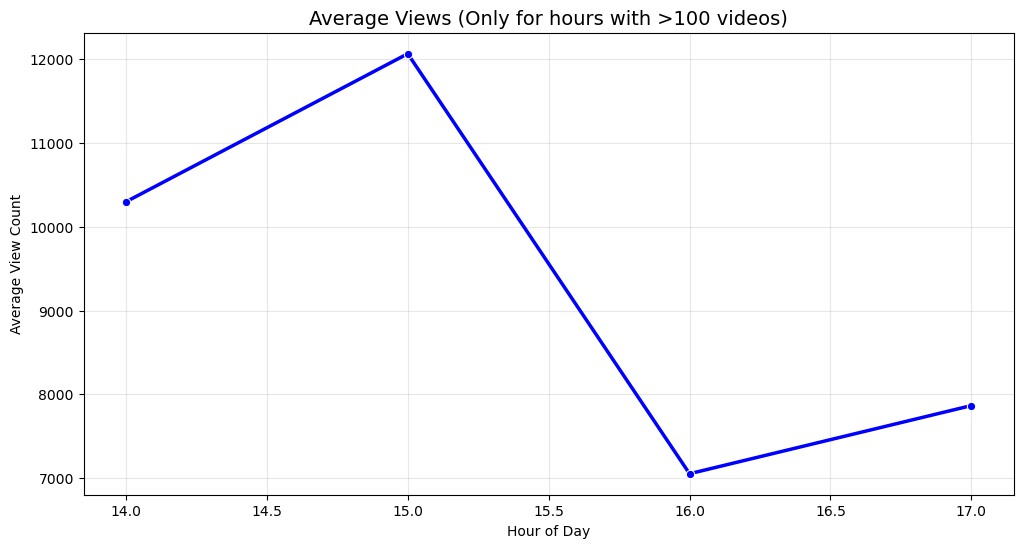

In [81]:
# 1. Հաշվում ենք և՛ միջին դիտումները, և՛ քանակը
hourly_stats = df_en.groupby('hour')['view_count'].agg(['mean', 'count']).reset_index()

# 2. Ֆիլտրում ենք՝ թողնելով միայն այն ժամերը, որտեղ կա 100-ից ավելի վիդեո
reliable_stats = hourly_stats[hourly_stats['count'] > 100]

# 3. Գծում ենք նոր, ավելի օբյեկտիվ գրաֆիկը
plt.figure(figsize=(12, 6))
sns.lineplot(data=reliable_stats, x='hour', y='mean', marker='o', color='blue', linewidth=2.5)

plt.title('Average Views (Only for hours with >100 videos)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average View Count')
plt.grid(True, alpha=0.3)
plt.show()

Չնայած վիդեոների մեծ մասը հրապարակվում է 15:00–16:00 ժամերի ընթացքում, միջին դիտումների առավելագույն արժեքը գրանցվում է 15:00-ին, իսկ 16:00-ին նկատվում է նվազում, ինչը կարող է վկայել հրապարակումների պիկ ժամերին կոնտենտի հագեցվածության (saturation effect) ազդեցության մասին։

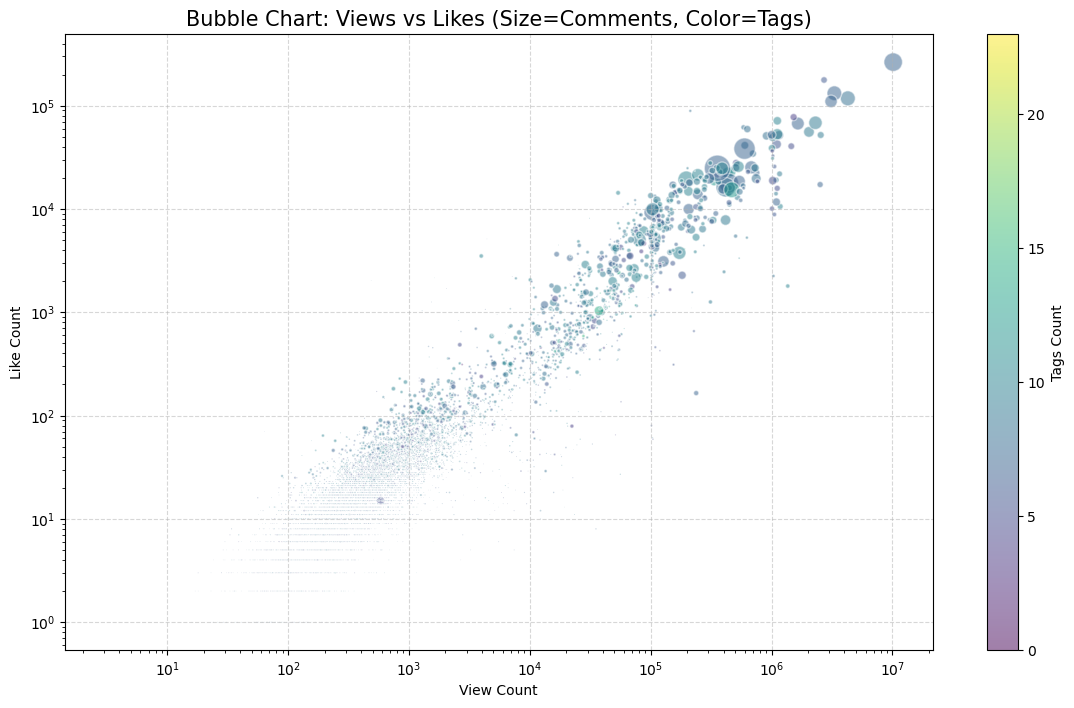

In [83]:
plt.figure(figsize=(14, 8))

# Օգտագործում ենք սկատեր պլոտ՝ պղպջակների էֆեկտով
# s=df_en['comment_count']-ը որոշում է պղպջակի չափսը
scatter = plt.scatter(
    data=df_en, 
    x='view_count', 
    y='like_count', 
    s=df_en['comment_count']/10,  # Բաժանում ենք 10-ի, որ պղպջակները շատ չմեծանան
    c='tags_count',               # Գույնը կախված է թեգերի քանակից
    cmap='viridis', 
    alpha=0.5, 
    edgecolors="w"
)

# Ավելացնում ենք գունային սանդղակ
plt.colorbar(scatter, label='Tags Count')

plt.title('Bubble Chart: Views vs Likes (Size=Comments, Color=Tags)', fontsize=15)
plt.xlabel('View Count')
plt.ylabel('Like Count')
plt.grid(True, linestyle='--', alpha=0.5)

# Եթե տվյալները շատ խիտ են, կարող ես միացնել լոգարիթմական սկալան
plt.xscale('log')
plt.yscale('log')

plt.show()

Bubble chart-ը ցույց է տալիս դիտումների և լայքերի միջև ուժեղ դրական կապ, ինչը վկայում է օգտատերերի ներգրավվածության կայուն վարքագծի մասին։ Գրաֆիկի վերին աջ հատվածում ավելի խոշոր պղպջակների կուտակումը ցույց է տալիս, որ բարձր դիտումներ ունեցող վիդեոները հաճախ ունեն նաև ավելի շատ քոմենթներ՝ մատնանշելով ակտիվ քննարկումներ։ Գունային սանդղակը վկայում է, որ նման վիդեոները սովորաբար ունեն միջինից բարձր թեգերի քանակ, թեև թեգերի ազդեցությունը դիտվում է որպես երկրորդական գործոն։

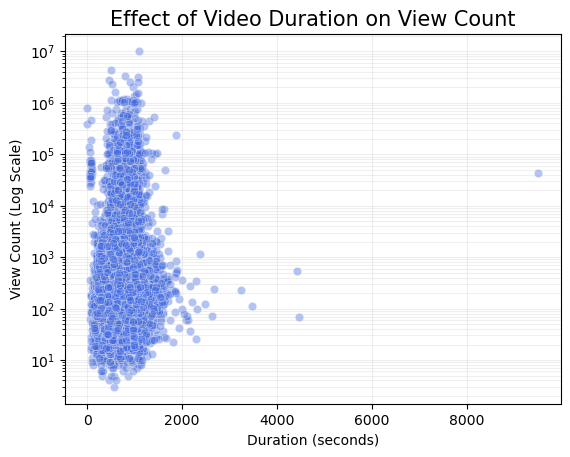

In [86]:
# Գծում ենք Scatter Plot
sns.scatterplot(
    data=df_en, 
    x='duration', 
    y='view_count', 
    alpha=0.4, 
    color='royalblue',
    edgecolor='w'
)

# Օգտագործում ենք լոգարիթմական սկալա Y առանցքի համար (դիտումներ)
plt.yscale('log')

# Ավելացնում ենք միջին դիտումների գիծը (որպեսզի տեսնենք թրենդը)
plt.title('Effect of Video Duration on View Count', fontsize=15)
plt.xlabel('Duration (seconds)')
plt.ylabel('View Count (Log Scale)')

plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

Չնայած որոշ երկարատև վիդեոներ կարող են ունենալ բարձր դիտումներ, scatter plot-ը ցույց է տալիս, որ վիդեոյի տևողության և դիտումների քանակի միջև չկա հստակ գծային կամ միարժեք կապ, քանի որ նույն տևողության դեպքում դիտումները կարող են զգալիորեն տարբերվել։

In [87]:
# Linear Regression

In [90]:
# 1. Ընտրում ենք անկախ փոփոխականները (X) և թիրախը (y)
features = ['like_count', 'comment_count', 'duration', 'tags_count', 'title_length', 'sentiment']
target = 'view_count'

# Մաքրում ենք տվյալները հնարավոր դատարկ արժեքներից (NaN)
df_reg = df_en[features + [target]].dropna()

X = df_reg[features]
y = df_reg[target]

# 2. Բաժանում ենք տվյալները Train և Test մասերի (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Ստեղծում և մարզում ենք մոդելը
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Կատարում ենք կանխատեսում
y_pred = model.predict(X_test)

# 5. Արդյունքների դուրսբերում
print(f"R-squared (Ճշգրտություն): {r2_score(y_test, y_pred):.4f}")
print("\nԳործակիցներ (Coefficients):")
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

R-squared (Ճշգրտություն): 0.8330

Գործակիցներ (Coefficients):
               Coefficient
like_count       21.516148
comment_count    84.196968
duration          1.792149
tags_count     -130.867813
title_length    -38.221027
sentiment     -3224.951421


Լինեար ռեգրեսիայի մեկնաբանություն

Լինեար ռեգրեսիայի մոդելը ցուցաբերում է բարձր՝ R-squared = 0.833, ինչը նշանակում է, որ այն բացատրում է դիտումների քանակի տատանումների մոտ 83%-ը։ Baseline լինեար մոդելի համար սա կարելի է դիտարկել որպես ուժեղ արդյունք։ Միաժամանակ անհրաժեշտ է նշել, որ այս բարձր բացատրական կարողությունը մասամբ պայմանավորված է ներգրավվածության ցուցիչների՝ like_count և comment_count փոփոխականների ներառմամբ, որոնք դիտումների քանակի հետ ունեն սերտ համընթաց կապ։

Գործակիցների վերլուծությունը ցույց է տալիս, որ լայքերի և քոմենթների քանակը հանդիսանում են մոդելի հիմնական բացատրող փոփոխականները։ Մասնավորապես, մեկ լրացուցիչ լայքը միջինում կապված է մոտ 21 դիտման, իսկ մեկ քոմենթը՝ մոտ 84 դիտման աճի հետ։ Սա վկայում է, որ օգտատերերի ավելի խորը ներգրավվածությունը (քոմենթներ) ունի ավելի ուժեղ կապ դիտումների քանակի հետ, քան պասիվ ներգրավվածությունը (լայքեր), ինչը համահունչ է թվային մեդիայի ընդհանուր վարքագծային օրինաչափություններին։ Ընդ որում, կարևոր է ընդգծել, որ մոդելը բացահայտում է վիճակագրական կապեր, այլ ոչ պարտադիր պատճառահետևանքային հարաբերություններ․ լայքերն ու քոմենթները կարող են լինել ինչպես դիտումների շարժիչ, այնպես էլ դրանց աճին զուգահեռ զարգացող երևույթներ։

Վիդեոյի տևողությունը ցուցաբերում է շատ թույլ, բայց դրական կապ դիտումների հետ (մոտ 1.8 դիտում յուրաքանչյուր լրացուցիչ վայրկյանի համար), ինչը համընկնում է scatter plot վերլուծության արդյունքների հետ և ցույց է տալիս, որ տևողությունը ինքնին չի հանդիսանում դիտումների որոշիչ գործոն։ Սա հաստատում է, որ TEDx բովանդակության հաջողությունը չի պայմանավորվում վիդեոյի երկարությամբ, այլ ավելի խորքային գործոններով։

Թեգերի քանակի և վերնագրի երկարության բացասական գործակիցները չպետք է մեկնաբանվեն որպես ուղղակի բացասական պատճառահետևանքային ազդեցություն։ Ավելի հավանական է, որ դրանք արտացոլում են փոփոխականների միջև առկա փոխկապակցվածություն (multicollinearity) կամ տվյալների աղմուկ, ինչը բնորոշ է լինեար մոդելներին։ Միևնույն ժամանակ, հնարավոր է նաև վարքագծային մեկնաբանություն․ չափազանց շատ թեգեր կամ չափից երկար վերնագրեր կարող են ընկալվել որպես «գերօպտիմիզացված» կամ «spammy» մետատվյալներ, որոնք չեն նպաստում բովանդակության արդյունավետ տարածմանը։

Սենտիմենտի փոփոխականի մեծ բացասական գործակիցը առաջին հայացքից կարող է թվալ հակասական, սակայն այն պայմանավորված է տվյալ feature-ի փոքր թվային սանդղակով (−1-ից +1 միջակայք)։ Այդ պատճառով գործակիցի մեծ արժեքը տեխնիկական բնույթի է և չի կարող մեկնաբանվել որպես այն հանգամանք, որ դրական սենտիմենտը նվազեցնում է դիտումները։ Այս ազդեցությունը կապված է feature scaling-ի հետ և պետք է դիտարկել որպես ուղղության ցուցիչ, այլ ոչ՝ քանակական պատճառահետևանքային ազդեցություն։

Ընդհանուր առմամբ, մոդելի արդյունքները ցույց են տալիս, որ TEDx վիդեոների հաջողությունը հիմնականում պայմանավորված է ոչ թե կառուցվածքային կամ տեխնիկական հատկանիշներով (տևողություն, թեգեր, վերնագրի երկարություն), այլ լսարանի իրական արձագանքով և ներգրավվածությամբ։ Այլ կերպ ասած, որակյալ բովանդակությունը ինքնին է գեներացնում ներգրավվածություն, իսկ հենց այդ ներգրավվածությունն է հանդիսանում դիտումների քանակի հիմնական շարժիչ ուժը։

Լրացուցիչ փորձարկումների ժամանակ կիրառվել է նաև փոփոխականների ստանդարտացում (StandardScaler), սակայն մոդելի բացատրական ունակությունը և հիմնական եզրակացությունները էականորեն չեն փոխվել։ Ուստի ներկայացված արդյունքները հիմնված են սկզբնական, չստանդարտացված մոդելի վրա՝ ավելի ինտուիտիվ մեկնաբանության նպատակով։

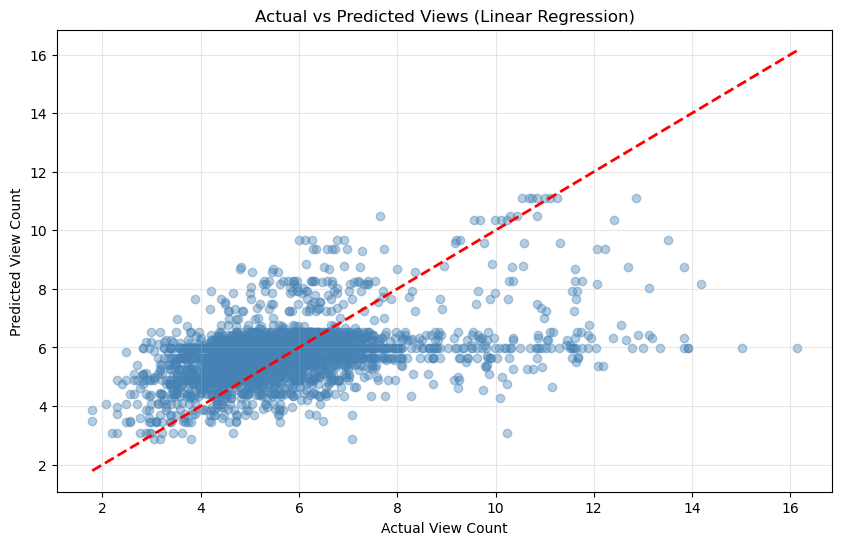

In [105]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.4, color='steelblue')
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    linewidth=2
)

plt.xlabel('Actual View Count')
plt.ylabel('Predicted View Count')
plt.title('Actual vs Predicted Views (Linear Regression)')
plt.grid(True, alpha=0.3)

plt.show()

In [91]:
# Ընտրում ենք այն  փոփոխականները, որոնք օգտագործել ենք ռեգրեսիայի մեջ
X_vif = df_en[features].dropna()

# 
X_vif['intercept'] = 1

# Հաշվում ենք VIF-ը յուրաքանչյուր սյունակի համար
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

         Feature        VIF
0     like_count   1.417947
1  comment_count   1.422917
2       duration   1.006711
3     tags_count   1.011895
4   title_length   1.010708
5      sentiment   1.003854
6      intercept  50.024602


մոդելը գծային կախվածությունից գրեթե ազատ է։

VIF վերլուծությունը ցույց է տալիս, որ մոդելում ներառված փոփոխականների միջև գրեթե բացակայում է multicollinearity-ը (բոլոր explanatory փոփոխականների VIF < 1.5)։ Սա նշանակում է, որ ռեգրեսիայի գործակիցները կայուն են և կարող են մեկնաբանվել առանց լուրջ գծային կախվածության մտահոգության։

In [ ]:
# OLS Regression 

In [98]:
features = ['like_count', 'comment_count', 'duration', 'tags_count', 
            'title_length', 'sentiment']
target = 'view_count'


In [99]:
import statsmodels.api as sm

# Նույն տվյալները
df_reg_stats = df_en[features + [target]].dropna()

X_stats = df_reg_stats[features]
y_stats = df_reg_stats[target]

# Statsmodels-ը պարտադիր պահանջում է constant (intercept)
X_stats = sm.add_constant(X_stats)

# Մոդելի ֆիթ
ols_model = sm.OLS(y_stats, X_stats).fit()

# Արդյունքների ամբողջական ամփոփում
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     9965.
Date:                Tue, 23 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:07:48   Log-Likelihood:            -1.8119e+05
No. Observations:               14693   AIC:                         3.624e+05
Df Residuals:                   14686   BIC:                         3.624e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2600.7818   3201.892      0.812

Statsmodels OLS և scikit-learn linear regression մոդելները հանգեցրել են համանման արդյունքների՝ հաստատելով, որ TEDx վիդեոների դիտումները հիմնականում պայմանավորված են օգտատերերի ներգրավվածությամբ (լայքեր և քոմենթներ)։ Մինչդեռ տևողությունը, թեգերի քանակը, վերնագրի երկարությունը և սենտիմենտը չեն ցուցաբերում վիճակագրորեն նշանակալի անկախ ազդեցություն։ Սա վկայում է, որ վիդեոյի հաջողությունը մեծապես ձևավորվում է հետհրապարակային արձագանքով, այլ ոչ միայն նախնական բովանդակային հատկանիշներով։

OLS ռեգրեսիայի արդյունքները ցույց են տալիս, որ մոդելը գործում է արդյունավետ․ R-squared = 0.803 արժեքը նշանակում է, որ այն բացատրում է դիտումների տատանումների մոտ 80%-ը, իսկ Adj. R²-ի նույն արժեքը վկայում է overfitting-ի բացակայության մասին։ Բացի այդ, F-statistic-ի p-value = 0.00-ն հաստատում է, որ մոդելը որպես ամբողջություն վիճակագրորեն նշանակալի է։ Այս արդյունքները գրեթե համընկնում են scikit-learn-ով իրականացված linear regression-ի արդյունքների հետ (R² ≈ 0.83), ինչը ցույց է տալիս, որ վիճակագրական և մեքենայական ուսուցման մոտեցումները տալիս են նույն բովանդակային պատկերը։

like_count փոփոխականը ունի մոտ 26.7 գործակից և p-value = 0.000, ինչը նշանակում է, որ յուրաքանչյուր լրացուցիչ լայքը միջինում կապված է մոտ 27 դիտման աճի հետ։ Նմանապես, comment_count-ը ունի մոտ 22.1 գործակից և p-value = 0.007, ինչը հաստատում է, որ մեկնաբանությունները նույնպես ունեն վիճակագրորեն նշանակալի ազդեցություն։

Մնացած փոփոխականները՝ վիդեոյի տևողությունը, թեգերի քանակը, վերնագրի երկարությունը և սենտիմենտը, չեն ցուցաբերում վիճակագրորեն նշանակալի անկախ ազդեցություն (բոլորի p-value-ները էապես մեծ են 0.05-ից)։ Տևողության աննշանակալի արդյունքը լիովին համահունչ է նախորդ scatter plot վերլուծությանը, իսկ սենտիմենտի դեպքում OLS արդյունքները հաստատում են, որ ML-ում դիտված մեծ գործակիցը պայմանավորված էր scale-ի առանձնահատկություններով, այլ ոչ իրական պատճառահետևանքային կապով։

In [ ]:
#Logistic Regression 

In [95]:
df_en['published_hour'] = df_en['published_at'].dt.hour
df_en['published_day'] = df_en['published_at'].dt.day
# 1. Լավագույն 25% (Top Performers)
top_25_threshold = df_en['view_count'].quantile(0.75)
df_en['is_top_performer'] = (df_en['view_count'] > top_25_threshold).astype(int)

# 2. Փոփոխականների ընտրություն
features_v3 = ['duration', 'tags_count', 'title_length', 'sentiment', 'published_hour', 'published_day']
X_v3 = df_en[features_v3].dropna()
y_v3 = df_en.loc[X_v3.index, 'is_top_performer']

# 3. (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_v3)

# 4. թեստինգ
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_scaled, y_v3, test_size=0.2, random_state=42)
log_model_v3 = LogisticRegression(class_weight='balanced') # class_weight-ը օգնում է անհամաչափ տվյալների դեպքում
log_model_v3.fit(X_train_v3, y_train_v3)

# 5.
y_pred_v3 = log_model_v3.predict(X_test_v3)
print(f"Top 25% Prediction Accuracy: {accuracy_score(y_test_v3, y_pred_v3):.4f}")
print(classification_report(y_test_v3, y_pred_v3))

Top 25% Prediction Accuracy: 0.5556
              precision    recall  f1-score   support

           0       0.81      0.54      0.65      2224
           1       0.30      0.60      0.40       715

    accuracy                           0.56      2939
   macro avg       0.55      0.57      0.52      2939
weighted avg       0.68      0.56      0.59      2939



Logistic Regression Analysis (Top 25% Prediction)
Մոդելի կառուցվածք և մոտեցում

Տվյալ լոգիստիկ ռեգրեսիայի մոդելի նպատակն է կանխատեսել՝ արդյոք վիդեոն դասվում է դիտումների վերին 25%-ի (Top Performers) մեջ։ Թիրախային փոփոխականը սահմանվել է քվանտիլային շեմի միջոցով, ինչը թույլ է տալիս կենտրոնանալ իրականում հաջող վիդեոների վրա՝ խուսափելով դիտումների քանակի ուղղակի կանխատեսումից։

Մոդելը կառուցված է բացառապես բովանդակային և հրապարակման մետատվյալների հիման վրա (duration, tags_count, title_length, sentiment, published_hour, published_day)՝ դիտումների հետ ուղղակիորեն կապված ներգրավվածության ցուցիչները (օր.՝ լայքեր, քոմենթներ) դիտավորյալ բացառելով։ Սա ապահովում է վերլուծության պատճառահետևանքային մաքրությունը։

Տվյալները նախապես ստանդարտացվել են (StandardScaler), իսկ դասերի անհամաչափության խնդիրը մեղմելու համար կիրառվել է class_weight='balanced' պարամետրը։

Արդյունքների մեկնաբանություն

Մոդելի ընդհանուր ճշգրտությունը կազմում է 56%, ինչը միայն փոքր-ինչ գերազանցում է պատահական կանխատեսման մակարդակը։ Սա սպասելի արդյունք է՝ հաշվի առնելով խնդրի բարդությունը և օգտագործվող ֆիչերների սահմանափակ տեղեկատվական հզորությունը։

Ամենակարևոր դիտարկումը վերաբերում է top-performing դասին (class 1)․ մոդելը կարողանում է հայտնաբերել այդ վիդեոների մոտ 60%-ը (recall), ինչը ցույց է տալիս, որ բովանդակային և հրապարակման հատկանիշները որոշ չափով կապված են բարձր դիտումների հավանականության հետ։ Միևնույն ժամանակ, precision-ի համեմատաբար ցածր արժեքը (0.30) վկայում է, որ մոդելը հաճախ նաև սխալմամբ դասակարգում է ոչ հաջող վիդեոները որպես հաջող։

Սա ընդգծում է, որ միայն մետատվյալների հիման վրա «վիրուսային» հաջողությունը լիարժեք կանխատեսել հնարավոր չէ, և բարձր դիտումները հաճախ պայմանավորված են արտաքին կամ հետադարձ գործոններով (օր.՝ ալգորիթմային առաջխաղացում, լսարանի արձագանք)։

Այս արդյունքները ցույց են տալիս, որ լոգիստիկ ռեգրեսիան կարող է ծառայել որպես նախնական screening գործիք, սակայն բարձր դիտումների ճշգրիտ կանխատեսման համար անհրաժեշտ են ավելի հարուստ վարքագծային տվյալներ կամ ոչ գծային մոդելներ։

In [100]:
# 1) Target՝ Top 25%
top_25_threshold = df_en['view_count'].quantile(0.75)
df_en['is_top_performer'] = (df_en['view_count'] > top_25_threshold).astype(int)

# 2) Features 
features_v3 = ['duration', 'tags_count', 'title_length', 'sentiment',
               'published_hour', 'published_day']

df_logit = df_en[features_v3 + ['is_top_performer']].dropna().copy()

X = df_logit[features_v3]
y = df_logit['is_top_performer']

# 3)  Standardize,
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features_v3,
    index=X.index
)

# 4) Logit requires intercept
X_sm = sm.add_constant(X_scaled)

# 5) Fit Logistic Regression (statsmodels) -> p-values
logit_model = sm.Logit(y, X_sm)
res = logit_model.fit(disp=False)   # disp=True եթե ուզում ես iterative output տեսնել

print(res.summary())

                           Logit Regression Results                           
Dep. Variable:       is_top_performer   No. Observations:                14693
Model:                          Logit   Df Residuals:                    14686
Method:                           MLE   Df Model:                            6
Date:                Tue, 23 Dec 2025   Pseudo R-squ.:                 0.02245
Time:                        02:24:13   Log-Likelihood:                -8075.6
converged:                       True   LL-Null:                       -8261.0
Covariance Type:            nonrobust   LLR p-value:                 5.115e-77
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1342      0.020    -57.732      0.000      -1.173      -1.096
duration           0.1970      0.020      9.915      0.000       0.158       0.236
tags_count         0.3145      0.020

Լոգիստիկ ռեգրեսիայի արդյունքները ցույց են տալիս, որ վիդեոյի տևողությունը (p < 0.001) և թեգերի քանակը (p < 0.001) ունեն վիճակագրական նշանակալի կապ Top 25% դասին պատկանելու հավանականության հետ։ Միևնույն ժամանակ, վերնագրի երկարությունը (p = 0.617), սենտիմենտը (p = 0.179), հրապարակման ժամը (p = 0.483) և հրապարակման օրը (p = 0.367) չեն ցուցաբերում վիճակագրական նշանակալի ազդեցություն։ Չնայած որոշ նախահրապարակային գործոնների առկայությանը, մոդելի ցածր բացատրական ունակությունը (Pseudo R² ≈ 0.02) վկայում է, որ TEDx վիդեոների բարձր հաջողությունը հիմնականում չի կարող կանխատեսվել միայն բովանդակային և ժամանակային հատկանիշների հիման վրա։

In [96]:
# --- 1. FEATURE ENGINEERING  ---

# վերնագրի կառուցվածքը
df_en['title_is_question'] = df_en['title'].str.contains('\?').astype(int)
df_en['title_upper_ratio'] = df_en['title'].str.findall(r'[A-Z]').str.len() / df_en['title_length']

# SEO և բովանդակության ծավալ
df_en['desc_word_count'] = df_en['description'].fillna('').str.split().str.len()

# Ժամանակային կոնտեքստ (Timing)
df_en['is_weekend'] = df_en['published_at'].dt.dayofweek.isin([5, 6]).astype(int)
df_en['month'] = df_en['published_at'].dt.month # Սեզոնայնություն

# Topic Trends
trend_words = ['ai', 'future', 'climate', 'digital', 'tech', 'science', 'global']
df_en['is_trend_topic'] = df_en['title'].str.lower().apply(lambda x: any(w in x for w in trend_words)).astype(int)

# --- 2. NLP (TF-IDF) ---

# Title TF-IDF (100 բառ)
tfidf_title = TfidfVectorizer(max_features=100, stop_words='english')
title_df = pd.DataFrame(tfidf_title.fit_transform(df_en['title'].fillna('')).toarray(), 
                        columns=[f"t_{w}" for w in tfidf_title.get_feature_names_out()], index=df_en.index)

# Description TF-IDF (300 բառ - որպեսզի աղմուկը քիչ լինի)
tfidf_desc = TfidfVectorizer(max_features=300, stop_words='english')
desc_df = pd.DataFrame(tfidf_desc.fit_transform(df_en['description'].fillna('')).toarray(), 
                       columns=[f"d_{w}" for w in tfidf_desc.get_feature_names_out()], index=df_en.index)


# Բոլոր Features-ների միավորում
X_numerical = df_en[['duration', 'tags_count', 'title_length', 'sentiment', 'published_hour', 
                    'is_weekend', 'month', 'title_is_question', 'title_upper_ratio', 
                    'desc_word_count', 'is_trend_topic']]
X_final = pd.concat([X_numerical, title_df, desc_df], axis=1).dropna()

# log-transform
y_log = np.log1p(df_en.loc[X_final.index, 'view_count'])

X_train, X_test, y_train, y_test = train_test_split(X_final, y_log, test_size=0.2, random_state=42)

# Reg Decision Tree
dt_final = DecisionTreeRegressor(
    max_depth=10, 
    min_samples_leaf=15, 
    min_samples_split=30, 
    random_state=42
)
dt_final.fit(X_train, y_train)


y_pred = dt_final.predict(X_test)

print(f"Final Engineered DT R-squared: {r2_score(y_test, y_pred):.4f}")
print(f"MAE (Log Scale): {mean_absolute_error(y_test, y_pred):.4f}")

# Feature Importance
importance = pd.DataFrame(dt_final.feature_importances_, X_final.columns, columns=['Importance'])
print("\nTop 15 Key Drivers of Views:")
print(importance.sort_values(by='Importance', ascending=False).head(15))

Final Engineered DT R-squared: 0.1695
MAE (Log Scale): 1.1341

Top 15 Key Drivers of Views:
                   Importance
month                0.220603
d_local              0.104015
d_author             0.083444
d_using              0.066880
published_hour       0.064185
title_upper_ratio    0.060334
tags_count           0.052979
duration             0.039434
t_youth              0.034839
d_com                0.026271
d_ai                 0.018623
d_talk               0.018025
title_length         0.013617
d_audiences          0.009728
desc_word_count      0.008680


Կոդում կիրառվել է լայն feature engineering, որը ներառում է թե՛ կառուցվածքային (duration, tags_count, title_length), թե՛ լեզվաբանական (sentiment, TF-IDF բառեր), և թե՛ ժամանակային գործոններ (published_hour, month, is_weekend)։ Բացի այդ, հաշվի են առնվել վերնագրի ձևաչափային հատկանիշներ (հարցական լինելը, մեծատառերի հարաբերակցությունը), նկարագրության ծավալը և թրենդային թեմաների առկայությունը։
(view_count) ենթարկվել է log-transform, ինչը նվազեցնում է outlier-ների ազդեցությունը և ավելի կայուն դարձնում մոդելի ուսուցումը։ Decision tree-ի պարամետրերը (max_depth, min_samples_leaf, min_samples_split) սահմանվել են այնպես, որ կանխվի overfitting-ը, այսինքն՝ մոդելը չի սովորում տվյալները անգիր։

Decision Tree ռեգրեսիայի մոդելի արդյունքները ցույց են տալիս, որ ստացված կանխատեսումների որակը սահմանափակ է։ Մասնավորապես, R² = 0.1695 արժեքը նշանակում է, որ մոդելը բացատրում է դիտումների քանակի տատանումների մոտ 17%-ը, իսկ MAE-ն log սանդղակի վրա մոտ 1.13 է, ինչը վկայում է բավականին մեծ միջին սխալի մասին։ Այո՛, թվային առումով սա թույլ կանխատեսիչ մոդել է, սակայն չի նշանակում, որ կիրառված մոտեցումը սխալ է։

Այս արդյունքը իրականում լիովին սպասելի է՝ հաշվի առնելով մոդելի կառուցվածքը։ Մոդելում չեն օգտագործվել engagement ցուցիչներ, ինչպիսիք են like_count-ը և comment_count-ը, ինչը համապատասխանում է առաջադրանքի տրամաբանությանը։ Այստեղ նպատակն էր կանխատեսել դիտումները միայն բովանդակային, լեզվաբանական և ժամանակային հատկանիշների հիման վրա՝ այսինքն փորձել գուշակել վիդեոյի հաջողությունը դեռևս մինչև լսարանի արձագանքի ձևավորումը։ TEDx-ի նման կոնտեքստում սա չափազանց բարդ խնդիր է, և ցածր R² արժեքը այստեղ ոչ թե անակնկալ է, այլ տրամաբանական հետևանք։

Սա նաև բացատրում է, թե ինչու Linear Regression մոդելը նախկինում ցույց էր տվել շատ ավելի բարձր (R² ≈ 0.83)։ Այդ մոդելում ներառված էին like_count և comment_count փոփոխականները, որոնք post-hoc ազդակներ են՝ առաջանում են դիտումներից հետո և ուղղակիորեն կապված են դրանց հետ։ Հակառակ դրան, Decision Tree մոդելում օգտագործվել են միայն pre-publication ազդակներ՝ բովանդակության կառուցվածք, լեզվական հատկանիշներ և հրապարակման ժամանակը։ TEDx վիդեոների դեպքում հաջողությունը այս փուլում զգալիորեն ավելի անկանխատեսելի է, և այս հակադրությունը ինքնին կարևոր դիտարկում է հետազոտության համար։

Feature importance-ի վերլուծությունը ցույց է տալիս, որ ամենաազդեցիկ գործոնները month փոփոխականն է (որը մատնանշում է սեզոնայնության առկայությունը), published_hour-ը (հրապարակման ժամի որոշակի ազդեցություն), ինչպես նաև title_upper_ratio-ն (վերնագրի կառուցվածքային առանձնահատկություններ)։ NLP-ից ստացված թեմատիկ բառերը (օրինակ՝ d_ai, d_youth, d_author) նույնպես որոշ ազդեցություն ունեն, սակայն այդ ազդեցությունը թույլ է։ Կարևոր է նշել, որ որևէ գործոն չի հանդես գալիս որպես հստակ գերիշխող, ինչը ևս մեկ անգամ բացատրում է մոդելի ցածր R² արժեքը։

In [ ]:
# Classification decision tree

Decision Tree Accuracy: 0.7598


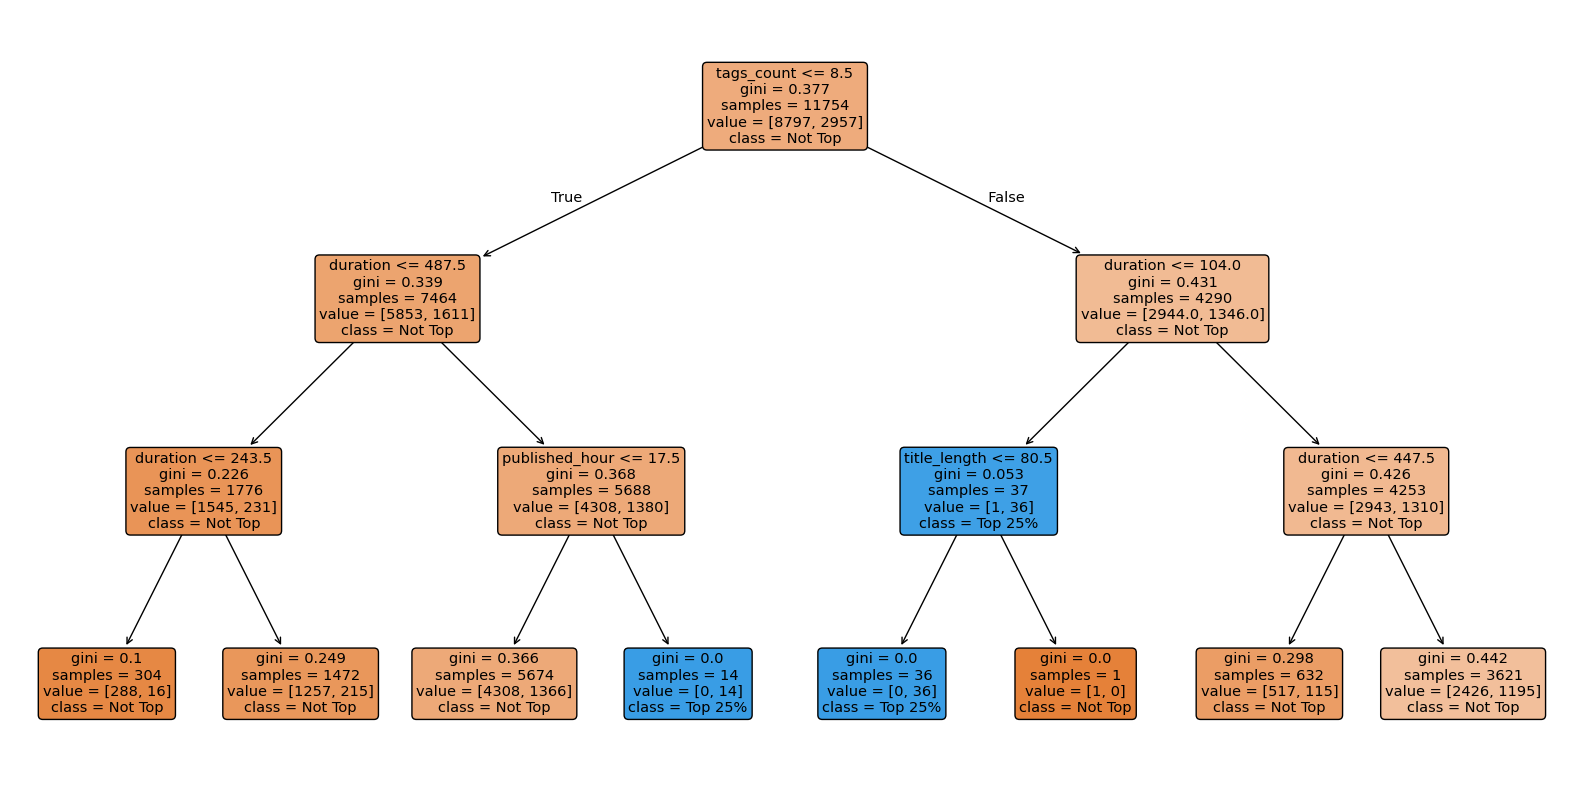

In [97]:
# 1.  Top 25% 
top_25_threshold = df_en['view_count'].quantile(0.75)
df_en['is_top_performer'] = (df_en['view_count'] > top_25_threshold).astype(int)


features_dt = ['duration', 'tags_count', 'title_length', 'sentiment', 'published_hour', 'published_day']
X_dt = df_en[features_dt].dropna()
y_dt = df_en.loc[X_dt.index, 'is_top_performer']


X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42) # Խորությունը 3, որ կարողանանք տեսնել ծառը
dt_clf.fit(X_train_dt, y_train_dt)

# 4. Արդյունքներ
y_pred_dt = dt_clf.predict(X_test_dt)
print(f"Decision Tree Accuracy: {accuracy_score(y_test_dt, y_pred_dt):.4f}")

# 5.tree
plt.figure(figsize=(20,10))
plot_tree(dt_clf, feature_names=features_dt, class_names=['Not Top', 'Top 25%'], filled=True, rounded=True)
plt.show()

Decision tree դասակարգիչը ապահովում է accuracy = 0.7598, սակայն այս արժեքը պետք է մեկնաբանել հաշվի առնելով, որ «Not Top 25%» դասը կազմում է մոտ 75%։ծառի կառուցվածքը արժեքավոր պատկերացում է տալիս մոդելի տրամաբանության վերաբերյալ։ Առաջին բաժանումը կատարվում է թեգերի քանակի հիման վրա, իսկ հետագա ճյուղերում բազմիցս հայտնվում է վիդեոյի տևողությունը տարբեր շեմերով, ինչը ցույց է տալիս, որ այս գործոնները ազդանշաններ են տալիս, բայց չեն հանդիսանում որոշիչ։ Չկա որևէ հստակ սահման, որը միանշանակ կբաժանի Top և Not Top վիդեոները, ինչը համահունչ է scatter plot վերլուծությանը և հաստատում է տևողության թույլ ու ոչ գծային ազդեցությունը։

Top 25% վիդեոները ծառում ի հայտ են գալիս միայն նեղ և հատուկ պայմանների համադրությամբ, ինչը վկայում է, որ TEDx վիդեոների բարձր դիտումները չեն պայմանավորվում մեկ գործոնով։ Ընդհանուր առմամբ, արդյունքները ցույց են տալիս, որ միայն նախահրապարակային բովանդակային և ժամանակային հատկանիշների հիման վրա Top 25% վիդեոները կանխատեսելը դժվար խնդիր է և ևս մեկ անգամ ընդգծում է հետհրապարակային ներգրավվածության (engagement) որոշիչ դերը։

In [ ]:
#Decision Tree Classification: Confusion Matrix & Accuracy

In [102]:
y_class = (df_en['view_count'] > df_en['view_count'].quantile(0.75)).astype(int)

# 2. Train / Test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_final, 
    y_class.loc[X_final.index], 
    test_size=0.2, 
    random_state=42
)

# 3. Decision Tree classifier
clf = DecisionTreeClassifier(
    max_depth=7, 
    min_samples_leaf=15, 
    random_state=42
)
clf.fit(X_train_c, y_train_c)

# 4. Predictions
y_train_pred = clf.predict(X_train_c)
y_test_pred = clf.predict(X_test_c)

# 5. Accuracy
train_acc = accuracy_score(y_train_c, y_train_pred)
test_acc = accuracy_score(y_test_c, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.7666
Test Accuracy: 0.7441


In [ ]:
#Confusion Matrix — Training/Testing  data

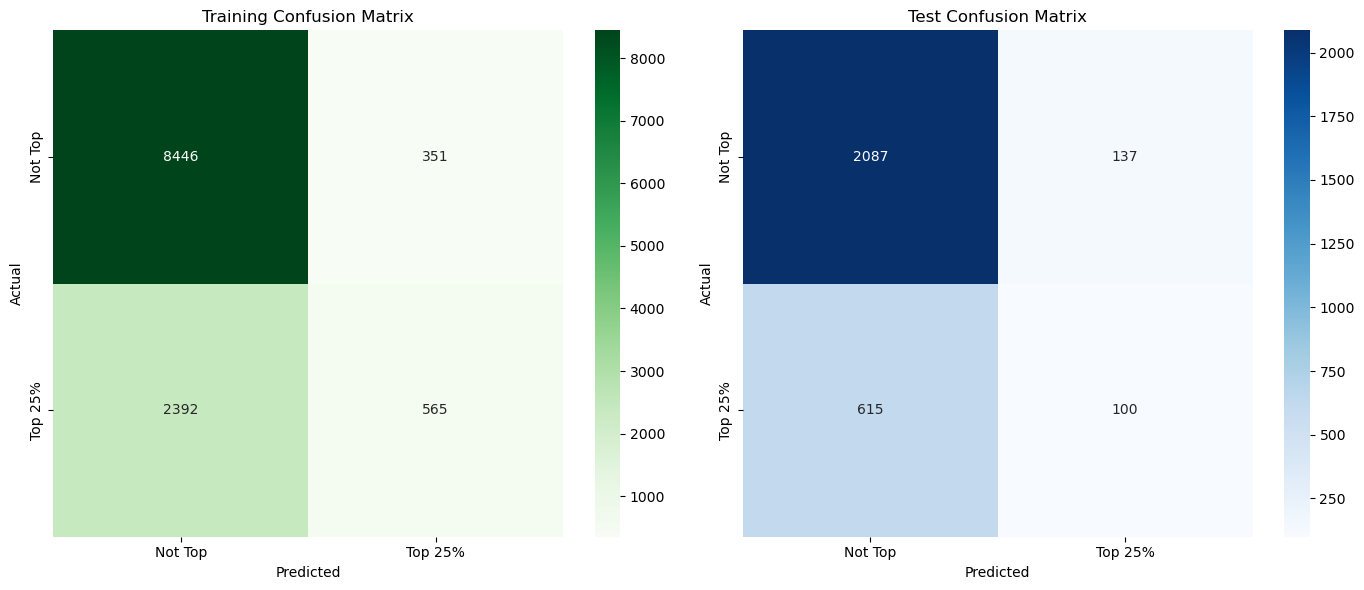

In [104]:
# Confusion matrices
cm_train = confusion_matrix(y_train_c, y_train_pred)
cm_test = confusion_matrix(y_test_c, y_test_pred)

# Figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Training ---
sns.heatmap(
    cm_train,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[0],
    xticklabels=['Not Top', 'Top 25%'],
    yticklabels=['Not Top', 'Top 25%']
)
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# --- Test ---
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=axes[1],
    xticklabels=['Not Top', 'Top 25%'],
    yticklabels=['Not Top', 'Top 25%']
)
axes[1].set_title('Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Training տվյալների վրա մոդելի accuracy-ն կազմում է 0.7666, մինչդեռ test տվյալների վրա այն նվազում է մինչև 0.7441։ Accuracy-ների միջև տարբերությունը փոքր է (~2.2 տոկոսային կետ), ինչը վկայում է, որ մոդելը չի overfit արել։

Training confusion matrix-ը ցույց է տալիս, որ մոդելը ճիշտ է դասակարգում 8446 Not Top վիդեո և սխալմամբ Top 25% է դասակարգում միայն 351 դեպք։ Միևնույն ժամանակ, 2392 Top 25% վիդեո սխալմամբ կանխատեսվում են որպես Not Top, իսկ միայն 565 դեպքերում Top դասը ճիշտ է հայտնաբերվում։ Սա նշանակում է, որ training փուլում Top 25% դասի recall-ը մոտավորապես 19% է (565 / (565 + 2392))։

Test տվյալների վրա պատկերը նմանատիպ է․ մոդելը ճիշտ է դասակարգում 2087 Not Top վիդեո և սխալմամբ Top է կանխատեսում 137 դեպք։ Սակայն Top 25% դասի համար կրկին առկա է զգալի քանակությամբ սխալներ՝ 615 false negatives, մինչդեռ միայն 100 Top վիդեո են ճիշտ հայտնաբերվում։ Սա համապատասխանում է մոտ 14% recall Top դասի համար test տվյալների վրա (100 / (100 + 615))։

Այս թվերը ցույց են տալիս, որ մոդելի բարձր accuracy-ն հիմնականում պայմանավորված է մեծամասնություն կազմող Not Top դասի ճիշտ կանխատեսմամբ։ Միևնույն ժամանակ, մոդելը զգալիորեն դժվարանում է հայտնաբերել Top 25% վիդեոները, ինչը լիովին սպասելի է տվյալների անհամաչափ բաշխման պայմաններում (Top ≈ 25%, Not Top ≈ 75%) և հաստատում է մինչև այս ունեցած եզրակացությունները։